#### Import Modules

In [18]:
import os
import numpy as np
import pandas as pd
# from collections import OrderedDict
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolDrawOptions
from rdkit.Chem import Draw
# import cairosvg
# import xml.etree.ElementTree as ET
# from functools import partial
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
import seaborn as sns
RDLogger.DisableLog('rdApp.*')

#### Define Functions

In [11]:
def HAC(mol):
    return mol.GetNumHeavyAtoms()


def add_hac(df):
    mols = list(map(MolFromSmiles, df['scaffold']))
    df['HAC'] = list(map(HAC, mols))
    return df


def get_mol(smi_or_mol):
    """convert smiles to mol. (copied from molgpt)
    """
    if isinstance(smi_or_mol, str):
        if len(smi_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smi_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smi_or_mol


def murcko_scaffold(smi_or_mol):
    mol = get_mol(smi_or_mol)
    if mol is None:
        return None
    return MurckoScaffoldSmiles(mol=mol)


def plot_smiles_group(smiles_list, save_path, substructure_list=None, n_per_mol=None,
                      img_size=None, descriptions=None):
    kwargs = {}
    kwargs['useSVG'] = False
    kwargs['returnPNG'] = False
    # kwargs['vspace'] = 2

    molecules = list(map(Chem.MolFromSmiles, smiles_list))
    kwargs['mols'] = molecules
    
    if substructure_list is not None:
        substr_mols = list(map(Chem.MolFromSmiles, substructure_list))
        highlights = []
        for i, mol in enumerate(molecules):
            match = mol.GetSubstructMatch(substr_mols[i])
            atom_highlights = set(match)
            bond_highlights = set()
            for atom_idx in match:
                atom_bonds = mol.GetAtomWithIdx(atom_idx).GetBonds()
                for bond in atom_bonds:
                    if bond.GetBeginAtomIdx() in match and bond.GetEndAtomIdx() in match:
                        bond_highlights.add(bond.GetIdx())
            highlights.append((atom_highlights, bond_highlights))
        kwargs['highlightAtomLists'] = [hl_atoms for hl_atoms, _ in highlights]
        kwargs['highlightBondLists'] = [hl_bonds for _, hl_bonds in highlights]

    draw_options = Draw.MolDrawOptions()
    # draw_options.legendFraction = 0.2
    draw_options.legendFontSize = 24
    # draw_options.rowSpacing = 0.2
    # kwargs['subImgSize'] = draw_options
    
    if n_per_mol is not None:
        kwargs['molsPerRow'] = n_per_mol
    if img_size is not None:
        kwargs['subImgSize'] = img_size
    if descriptions is not None:
        kwargs['legends'] = descriptions
    kwargs['drawOptions'] = draw_options

    img = Draw.MolsToGridImage(**kwargs)

    img.save(save_path)
    
    
# def plot_highlighted_smiles_group(
#         smiles,
#         save_path,
#         img_size,
#         n_per_mol,
#         substructure_smiles=None,
#         highlight_color=(0, 1, 0),
#         descriptions=None
#     ):
#     molecules = list(map(Chem.MolFromSmiles, smiles))
        
#     # for mol in molecules:
#     #     rdDepictor.Compute2DCoords(mol)

#     kwargs = {}
#     kwargs['mols'] = molecules
#     kwargs['molsPerRow'] = n_per_mol
#     kwargs['subImgSize'] = img_size
#     kwargs['useSVG'] = False
#     kwargs['returnPNG'] = False

#     if substructure_smiles is not None:
#         substructure = Chem.MolFromSmiles(substructure_smiles)

#         highlights = []
#         for mol in molecules:
#             match = mol.GetSubstructMatch(substructure)
#             atom_highlights = set(match)
#             bond_highlights = set()
#             for atom_idx in match:
#                 atom_bonds = mol.GetAtomWithIdx(atom_idx).GetBonds()
#                 for bond in atom_bonds:
#                     if bond.GetBeginAtomIdx() in match and bond.GetEndAtomIdx() in match:
#                         bond_highlights.add(bond.GetIdx())
#             highlights.append((atom_highlights, bond_highlights))
        
#         kwargs['highlightAtomLists'] = [hl_atoms for hl_atoms, _ in highlights]
#         kwargs['highlightBondLists'] = [hl_bonds for _, hl_bonds in highlights]

#     # Create a custom MolDrawOptions object
#     draw_options = MolDrawOptions()
#     draw_options.highlightColour = highlight_color
#     draw_options.legendFontSize = 20
    
#     if descriptions is not None:
#         kwargs['legends'] = descriptions
#     kwargs['draw_options'] = draw_options
    
#     img = Draw.MolsToGridImage(**kwargs)

#     # img = Draw.MolsToGridImage(molecules, molsPerRow=n_per_mol, subImgSize=img_size,
#     #                             highlightAtomLists=[hl_atoms for hl_atoms, _ in highlights],
#     #                             highlightBondLists=[hl_bonds for _, hl_bonds in highlights],
#     #                             drawOptions=draw_options, useSVG=True,
#     #                             legends=descriptions
#     #                             )

#     img.save(save_path)

#     # root = ET.fromstring(img)
#     # width = int(root.attrib['width'].strip('px'))
#     # height = int(root.attrib['height'].strip('px'))

#     # png_data = cairosvg.svg2png(bytestring=img,
#     #                             output_width=width*1.6,
#     #                             output_height=height*1.6)
    
#     # with open(save_path, 'wb') as f:
#     #     f.write(png_data)

#### Define file path

In [12]:
file_path = '/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/'
file_name_list = ['scavaetf1-15', 'scavaetf2-16', 'scavaetf3-16']

#### HAC Distribution Plot of seen and unseen scaffolds

In [13]:
file_folder = "/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/"
train = pd.read_csv(os.path.join(file_folder, 'train_sample.csv'), index_col=[0])
test_scaffold = pd.read_csv(os.path.join(file_folder, 'test_scaffolds_sample.csv'), index_col=[0])

In [6]:
column1 = 'Seen scaffolds'
column2 = 'Unseen scaffolds'

mols = list(map(MolFromSmiles, train['scaffold']))
hac1 = list(map(HAC, mols))
mols = list(map(MolFromSmiles, test_scaffold['scaffold']))
hac2 = list(map(HAC, mols))

df = pd.DataFrame({ column1: hac1, column2: hac2 })
df.head()

,Seen scaffolds,Unseen scaffolds
0,10,16
1,18,19
2,17,15
3,21,23
4,15,23


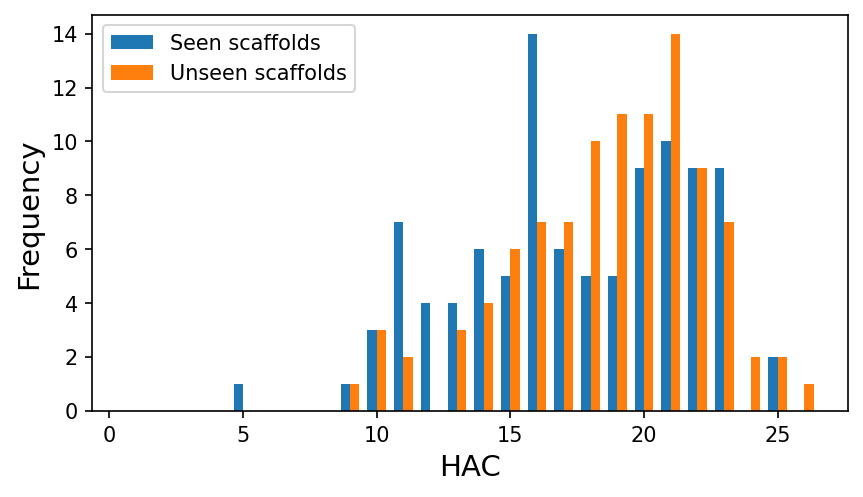

In [9]:
def plot_bar_chart_from_dataframe(df, column1, column2, x_label, y_label):
    freq1 = df[column1].value_counts()
    freq1 = freq1.sort_index()
    freq2 = df[column2].value_counts()
    freq2 = freq2.sort_index()
    
    max_val = max(freq1.index.max(), freq2.index.max())
    freq1 = freq1.reindex(np.arange(1, max_val+1), fill_value=0)
    freq2 = freq2.reindex(np.arange(1, max_val+1), fill_value=0)

    # Create a bar chart
    x_values = freq1.index
    width = 0.35

    fig, ax = plt.subplots(figsize=(6.5, 3.5), dpi=150)
    rects1 = ax.bar(x_values - width/2, freq1, width, label=column1)
    rects2 = ax.bar(x_values + width/2, freq2, width, label=column2)

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.legend()

    plt.show()
    

plot_bar_chart_from_dataframe(df, column1, column2, 
                              x_label='HAC',
                              y_label='Frequency')

#### Plot: Unique vs. Frequency in Train

In [8]:
n_samples = 10000
scaffold_source = 'train'


met1 = pd.read_csv(os.path.join(file_folder, file_name_list[0], scaffold_source, 'metric.csv'), index_col=[0])
met2 = pd.read_csv(os.path.join(file_folder, file_name_list[1], scaffold_source, 'metric.csv'), index_col=[0])
met3 = pd.read_csv(os.path.join(file_folder, file_name_list[2], scaffold_source, 'metric.csv'), index_col=[0])

In [9]:
unique_in_tolerance = (met1['unique_in_tolerance'] + met2['unique_in_tolerance'] + met3['unique_in_tolerance']) / 3
unique_in_tolerance = unique_in_tolerance * n_samples

In [10]:
train = pd.read_csv('../Data/raw/train.csv', index_col=[0])
freq_in_train = np.array([len(train[train.scaffold == sca]) for sca in met1['scaffold']])

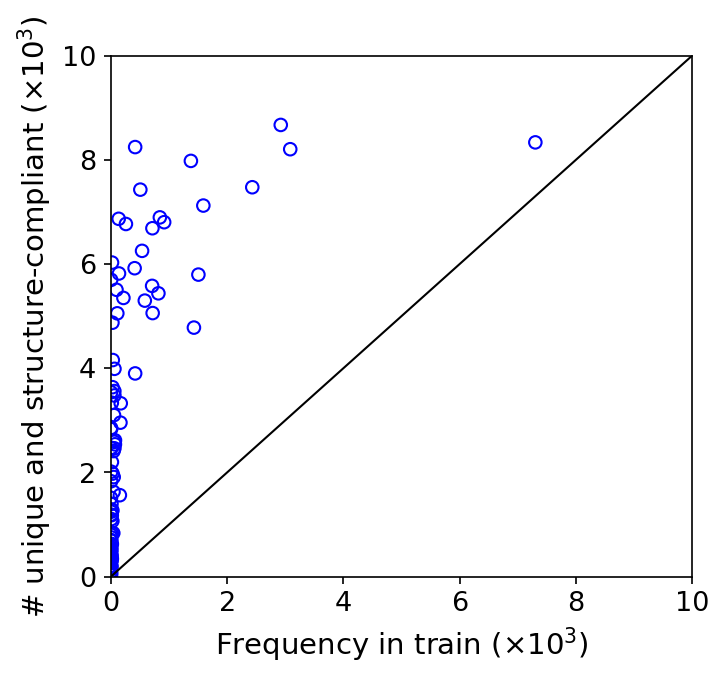

In [27]:
x = freq_in_train / 1000
y = unique_in_tolerance / 1000

xlabel = r'Frequency in train ($\times 10^3$)'
ylabel = r'# unique and structure-compliant ($\times 10^3$)'

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='blue')
plt.plot([0, 10], [0, 10], color='black', linewidth=1)

plt.xlabel(xlabel, fontsize=14)
plt.ylabel(ylabel, fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim((0, 10))
plt.ylim((0, 10))

plt.show()

#### "HAC of the scaffold" vs. valid/SSF and unique/intDiv

##### Get Metrics

In [11]:
# get metrics (train)

scaffold_source = 'train'

met1 = pd.read_csv(os.path.join(file_folder, file_name_list[0], scaffold_source, 'metric.csv'), index_col=[0])
met2 = pd.read_csv(os.path.join(file_folder, file_name_list[1], scaffold_source, 'metric.csv'), index_col=[0])
met3 = pd.read_csv(os.path.join(file_folder, file_name_list[2], scaffold_source, 'metric.csv'), index_col=[0])

met1 = add_hac(met1)
met2 = add_hac(met2)
met3 = add_hac(met3)

met_seen = pd.concat([met1, met2, met3]).groupby('scaffold').mean().reset_index()


# get metrics (scaffold test)

scaffold_source = 'test_scaffolds'

met4 = pd.read_csv(os.path.join(file_folder, file_name_list[0], scaffold_source, 'metric.csv'), index_col=[0])
met5 = pd.read_csv(os.path.join(file_folder, file_name_list[1], scaffold_source, 'metric.csv'), index_col=[0])
met6 = pd.read_csv(os.path.join(file_folder, file_name_list[2], scaffold_source, 'metric.csv'), index_col=[0])

met4 = add_hac(met4)
met5 = add_hac(met5)
met6 = add_hac(met6)

met_unseen = pd.concat([met4, met5, met6]).groupby('scaffold').mean().reset_index()

##### Plot 2 Figures Together

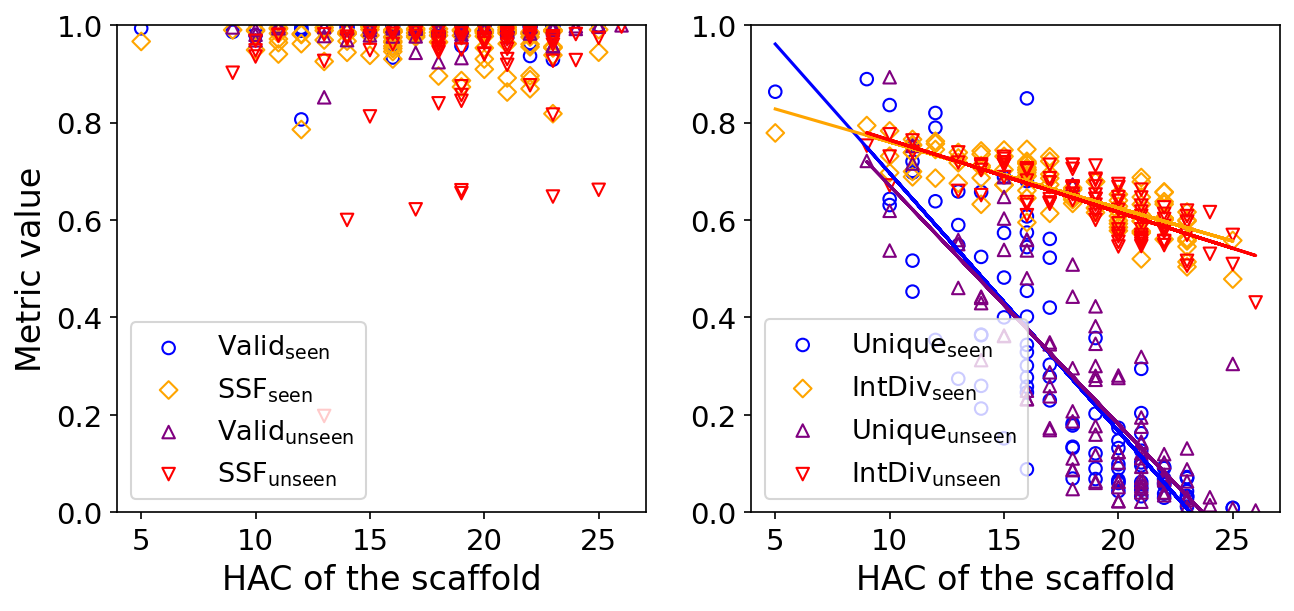

In [12]:
# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4.3), dpi=150)

# fig.text(0.5, -0.02, 'HAC of the scaffold', ha='center', fontsize=14)
# fig.text(0.05, 0.5, 'Metric value', va='center', rotation='vertical', fontsize=14)


# Data setup

x1 = met_seen['HAC']
met1_1 = met_seen['valid']
met2_1 = met_seen['SSF']

x2 = met_unseen['HAC']
met1_2 = met_unseen['valid']
met2_2 = met_unseen['SSF']

### the first plot

# Scatter plots
axes[0].scatter(x1, met1_1, label=r'$\mathdefault{Valid}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
axes[0].scatter(x1, met2_1, label=r'$\mathdefault{SSF}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
axes[0].scatter(x2, met1_2, label=r'$\mathdefault{Valid}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
axes[0].scatter(x2, met2_2, label=r'$\mathdefault{SSF}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

# Labels and legends
axes[0].set_xlabel('HAC of the scaffold', fontsize=16)
axes[0].set_ylabel('Metric value', fontsize=16)
axes[0].legend(fontsize=13, loc='lower left')


# Ticks
axes[0].set_yticks(np.arange(0, 1.1, 0.2))
axes[0].tick_params(labelsize=14)
axes[0].set_ylim(0, 1)

### the second plot

x1 = met_seen['HAC']
met1_1 = met_seen['unique']
met2_1 = met_seen['intDiv']

x2 = met_unseen['HAC']
met1_2 = met_unseen['unique']
met2_2 = met_unseen['intDiv']

# Scatter plots
axes[1].scatter(x1, met1_1, label=r'$\mathdefault{Unique}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
axes[1].scatter(x1, met2_1, label=r'$\mathdefault{IntDiv}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
axes[1].scatter(x2, met1_2, label=r'$\mathdefault{Unique}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
axes[1].scatter(x2, met2_2, label=r'$\mathdefault{IntDiv}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

# Labels and legends
axes[1].set_xlabel('HAC of the scaffold', fontsize=16)
# axes[1].set_ylabel('Metric value', fontsize=16)
axes[1].legend(fontsize=13, loc='lower left')

# # Linear fits
m1, b1 = np.polyfit(x1, met1_1, deg=1)
m2, b2 = np.polyfit(x1, met2_1, deg=1)
axes[1].plot(x1, m1*np.array(x1) + b1, color='blue')
axes[1].plot(x1, m2*np.array(x1) + b2, color='orange')

m1, b1 = np.polyfit(x2, met1_2, deg=1)
m2, b2 = np.polyfit(x2, met2_2, deg=1)
axes[1].plot(x2, m1*np.array(x2) + b1, color='purple')
axes[1].plot(x2, m2*np.array(x2) + b2, color='red')

# Correlation coefficients
# r1_met1 = np.corrcoef(x1, met1_1)[0, 1]
# r1_met2 = np.corrcoef(x1, met2_1)[0, 1]
# r2_met1 = np.corrcoef(x2, met1_2)[0, 1]
# r2_met2 = np.corrcoef(x2, met2_2)[0, 1]

# axes[1].text(0.44, 0.24, rf'r = {r1_met1:.2f}', transform=axes[1].transAxes, fontsize=12, color='blue')
# axes[1].text(0.44, 0.172, rf'r = {r1_met2:.2f}', transform=axes[1].transAxes, fontsize=12, color='orange')
# axes[1].text(0.44, 0.106, rf'r = {r2_met1:.2f}', transform=axes[1].transAxes, fontsize=12, color='purple')
# axes[1].text(0.44, 0.04, rf'r = {r2_met2:.2f}', transform=axes[1].transAxes, fontsize=12, color='red')

# Ticks
axes[1].set_yticks(np.arange(0, 1.1, 0.2))
axes[1].tick_params(labelsize=14)
axes[1].set_ylim(0, 1)

# Show the plot
# plt.tight_layout()
plt.show()

##### Metric (unique, intDiv) vs. HAC of the scaffold

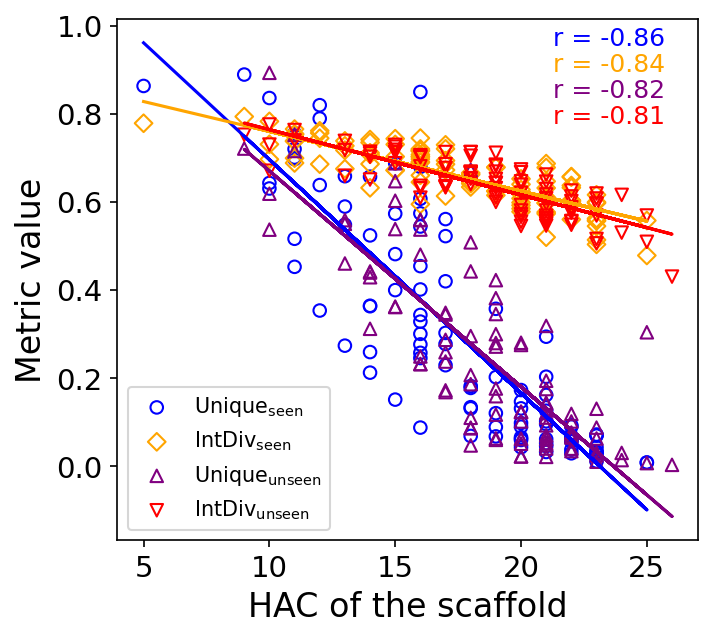

In [33]:
# import matplotlib as mpl
# mpl.rcParams['text.usetex'] = False

unique1 = met_seen['unique']
unique2 = met_unseen['unique']
intdiv1 = met_seen['intDiv']
intdiv2 = met_unseen['intDiv']
hac1 = met_seen['HAC']
hac2 = met_unseen['HAC']

plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(hac1, unique1, label=r'$\mathdefault{Unique}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(hac1, intdiv1, label=r'$\mathdefault{IntDiv}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')
plt.scatter(hac2, unique2, label=r'$\mathdefault{Unique}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(hac2, intdiv2, label=r'$\mathdefault{IntDiv}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel('HAC of the scaffold', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(np.arange(0, 25+1, 5), fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower left')

m1, b1 = np.polyfit(hac1, unique1, deg=1)
m2, b2 = np.polyfit(hac1, intdiv1, deg=1)
plt.plot(hac1, m1*np.array(hac1) + b1, color='blue')
plt.plot(hac1, m2*np.array(hac1) + b2, color='orange')

m1, b1 = np.polyfit(hac2, unique2, deg=1)
m2, b2 = np.polyfit(hac2, intdiv2, deg=1)
plt.plot(hac2, m1*np.array(hac2) + b1, color='purple')
plt.plot(hac2, m2*np.array(hac2) + b2, color='red')


r1_unique = np.corrcoef(hac1, unique1)[0, 1]
r1_intdiv = np.corrcoef(hac1, intdiv1)[0, 1]
r2_unique = np.corrcoef(hac2, unique2)[0, 1]
r2_intdiv = np.corrcoef(hac2, intdiv2)[0, 1]

plt.text(0.75, 0.95, rf'r = {r1_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.text(0.75, 0.90, rf'r = {r1_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='orange')
plt.text(0.75, 0.85, rf'r = {r2_unique:.2f}', transform=plt.gca().transAxes, fontsize=12, color='purple')
plt.text(0.75, 0.80, rf'r = {r2_intdiv:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')


plt.show()

##### Metric (valid, SSF) vs. HAC of the scaffold

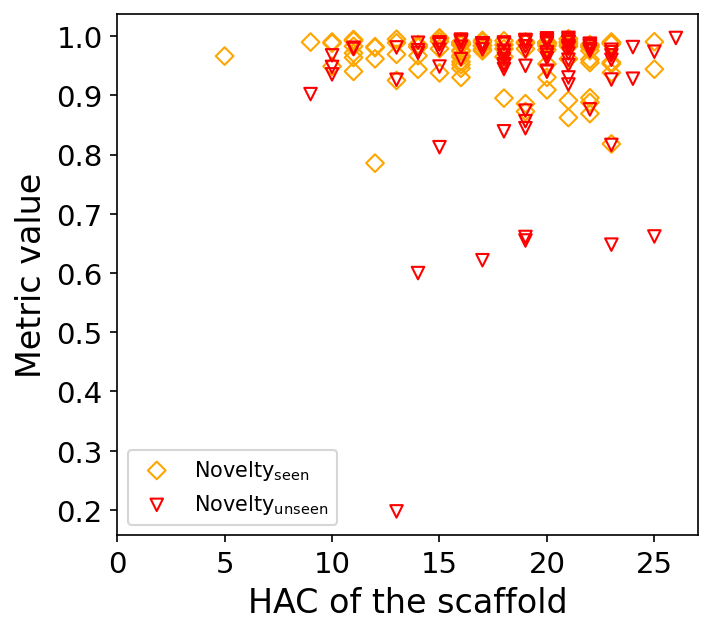

In [34]:
valid1 = met_seen['valid']
valid2 = met_unseen['valid']
novel1 = met_seen['SSF']
novel2 = met_unseen['SSF']
hac1 = met_seen['HAC']
hac2 = met_unseen['HAC']

plt.figure(figsize=(5, 4.6), dpi=150)
# plt.scatter(hac1, valid1, label=r'$\mathdefault{Valid}_{\mathdefault{seen}}$', marker='o', facecolors='none', edgecolors='blue')
plt.scatter(hac1, novel1, label=r'$\mathdefault{Novelty}_{\mathdefault{seen}}$', marker='D', facecolors='none', edgecolors='orange')

# plt.scatter(hac2, valid2, label=r'$\mathdefault{Valid}_{\mathdefault{unseen}}$', marker='^', facecolors='none', edgecolors='purple')
plt.scatter(hac2, novel2, label=r'$\mathdefault{Novelty}_{\mathdefault{unseen}}$', marker='v', facecolors='none', edgecolors='red')

plt.xlabel('HAC of the scaffold', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(np.arange(0, 25+1, 5), fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.legend(fontsize=10)
plt.legend(fontsize=10, loc='lower left')

plt.show()

### Case Study: Two Cases of The Highest and Lowest Successful_unique

In [5]:
file_folder = '/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/'

In [6]:
scaffold_source = 'test_scaffolds'

met1 = pd.read_csv(os.path.join(file_folder, file_name_list[0], scaffold_source, 'metric.csv'), index_col=[0])
met2 = pd.read_csv(os.path.join(file_folder, file_name_list[1], scaffold_source, 'metric.csv'), index_col=[0])
met3 = pd.read_csv(os.path.join(file_folder, file_name_list[2], scaffold_source, 'metric.csv'), index_col=[0])

met1 = add_hac(met1)
met2 = add_hac(met2)
met3 = add_hac(met3)

scaffold_list = met1['scaffold']
met_unseen = pd.concat([met1, met2, met3], axis=0).reset_index().groupby('index').mean()
met_unseen['scaffold'] = scaffold_list

In [26]:
best_met = met_unseen[met_unseen['unique_in_tolerance'] == met_unseen['unique_in_tolerance'].max()]
best_id = best_met.index[0]
best_scaffold = best_met.loc[best_id, 'scaffold']

print(f'Case with the highest successful_unique (ID = {best_id}; scaffold = {best_scaffold}):\n', best_met)

smi1 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/scavaetf1-15/test_scaffolds/gen{best_id}.csv', index_col=[0])
smi2 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/scavaetf2-16/test_scaffolds/gen{best_id}.csv', index_col=[0])
smi3 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/scavaetf3-16/test_scaffolds/gen{best_id}.csv', index_col=[0])

smi = pd.concat([smi1, smi2, smi3], axis=0).reset_index(drop=True)

smi['mol'] = smi['smiles'].apply(lambda x: get_mol(x))
best_smi = smi.dropna(subset='mol')
best_smi['scaffold'] = best_smi['smiles'].apply(lambda x: murcko_scaffold(x))
best_smi = best_smi[best_smi.scaffold == best_scaffold]
best_smi = best_smi.drop_duplicates('smiles')

sampled_smiles = best_smi.sample(n=12)

plot_smiles_group(smiles_list=sampled_smiles['smiles'],
                  substructure_list=sampled_smiles['scaffold'],
                  n_per_mol=4, img_size=(400, 220), save_path='./4.png')

Case with the highest successful_unique (ID = 76; scaffold = c1ccc2ncccc2c1):
           valid    unique     novel    intDiv       SSF     sim80  \
index                                                               
76     0.990167  0.892975  0.999134  0.775688  0.935555  0.938145   

       valid_in_tolerance  unique_in_tolerance   HAC        scaffold  
index                                                                 
76                 0.9263               0.8219  10.0  c1ccc2ncccc2c1  


<ipython-input-26-f662f35b5833>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_smi['scaffold'] = best_smi['smiles'].apply(lambda x: murcko_scaffold(x))


In [27]:
worst_met = met_unseen[met_unseen['unique_in_tolerance'] == met_unseen['unique_in_tolerance'].min()]

worst_id = worst_met.index[0]
worst_scaffold = worst_met.loc[worst_id, 'scaffold']

print(f'Case with the highest successful_unique (ID = {worst_id}; scaffold = {worst_scaffold}):\n', best_met)

smi1 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/scavaetf1-15/test_scaffolds/gen{worst_id}.csv', index_col=[0])
smi2 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/scavaetf2-16/test_scaffolds/gen{worst_id}.csv', index_col=[0])
smi3 = pd.read_csv(f'/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/scavaetf3-16/test_scaffolds/gen{worst_id}.csv', index_col=[0])

smi = pd.concat([smi1, smi2, smi3], axis=0).reset_index(drop=True)

smi['mol'] = smi['smiles'].apply(lambda x: get_mol(x))
worst_smi = smi.dropna(subset='mol')
worst_smi['scaffold'] = worst_smi['smiles'].apply(lambda x: murcko_scaffold(x))
worst_smi = worst_smi[worst_smi.scaffold == worst_scaffold]
worst_smi = worst_smi.drop_duplicates('smiles')

sampled_smiles = worst_smi.sample(n=12)

plot_smiles_group(smiles_list=sampled_smiles['smiles'],
                  substructure_list=sampled_smiles['scaffold'],
                  n_per_mol=4, img_size=(400, 220), save_path='./4.png')

Case with the highest successful_unique (ID = 57; scaffold = O=C(NCc1ccncc1)C1CC12CCN(C(=O)NC1CCCC1)C2):
           valid    unique     novel    intDiv       SSF     sim80  \
index                                                               
76     0.990167  0.892975  0.999134  0.775688  0.935555  0.938145   

       valid_in_tolerance  unique_in_tolerance   HAC        scaffold  
index                                                                 
76                 0.9263               0.8219  10.0  c1ccc2ncccc2c1  


<ipython-input-27-8cbe38525a76>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worst_smi['scaffold'] = worst_smi['smiles'].apply(lambda x: murcko_scaffold(x))


<ipython-input-8-6e02ee4e2cc7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_smi['scaffold'] = best_smi['smiles'].apply(lambda x: murcko_scaffold(x))


In [25]:
# plot_smiles_group(smiles=smi1['smiles'].tolist()[:12], img_size=(500, 500), save_path='./1.png')
# plot_smiles_group(smiles=smi2['smiles'].tolist()[:12], img_size=(500, 500), save_path='./2.png')
# plot_smiles_group(smiles=smi3['smiles'].tolist()[:12], img_size=(500, 500), save_path='./3.png')




### Show generated molecules with an unseen scaffold

In [5]:
file_folder = '/fileserver-gamma/chaoting/ML/GCT-Plus/Inference/moses/sca-sampling/'

In [6]:
testsca = pd.read_csv(os.path.join(file_folder, 'test_scaffolds_sample.csv'), index_col=[0])
mols = list(map(MolFromSmiles, testsca['scaffold']))
testsca['HAC'] = list(map(HAC, mols))

In [7]:
max_hac_sca = testsca[testsca.HAC == testsca['HAC'].max()]
min_hac_sca = testsca[testsca.HAC == testsca['HAC'].min()]

In [38]:
print(max_hac_sca)
print(min_hac_sca)

                                   scaffold  HAC
9  O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1   26
           scaffold  HAC
67  c1ccc2c(c1)CCS2    9


In [43]:
def get_gen_by_sid(sid):
    df1 = pd.read_csv(os.path.join(file_folder, f'scavaetf1-15/test_scaffolds/gen{sid}.csv'), index_col=[0])
    df2 = pd.read_csv(os.path.join(file_folder, f'scavaetf2-16/test_scaffolds/gen{sid}.csv'), index_col=[0])
    df3 = pd.read_csv(os.path.join(file_folder, f'scavaetf3-16/test_scaffolds/gen{sid}.csv'), index_col=[0])
    df = pd.concat([df1, df2, df3], axis=0).reset_index(drop=True)
    return df

def get_unique_compliant_gen(df, scaffold):
    df = df.drop_duplicates(subset='smiles')
    df['scaffold'] = df['smiles'].apply(lambda x: murcko_scaffold(x))
    df = df[df.scaffold == scaffold]
    df = df.reset_index(drop=True)
    return df


In [44]:
max_gen = get_gen_by_sid(max_hac_sca.index[0])
max_gen_found = get_unique_compliant_gen(max_gen, max_hac_sca['scaffold'].iloc[0])

min_gen = get_gen_by_sid(min_hac_sca.index[0])
min_gen_found = get_unique_compliant_gen(min_gen, min_hac_sca['scaffold'].iloc[0])

<ipython-input-43-6ec1cfae0df6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaffold'] = df['smiles'].apply(lambda x: murcko_scaffold(x))
<ipython-input-43-6ec1cfae0df6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scaffold'] = df['smiles'].apply(lambda x: murcko_scaffold(x))


In [45]:
min_gen_found

,smiles,scaffold
0,COCCCNC(=O)NC1CSc2ccc(Cl)cc21,c1ccc2c(c1)CCS2
1,CCC(CC)NC(=O)NCC1CSc2ccc(F)cc21,c1ccc2c(c1)CCS2
2,CC(C)CCNC(=O)C1(C)CSc2ccccc21,c1ccc2c(c1)CCS2
3,CCN(CC)C(=O)NC1CSc2ccc(C(=O)NCCO)cc21,c1ccc2c(c1)CCS2
4,CC(C)(C)C(=O)NC1CSc2ccc(C(F)(F)F)cc21,c1ccc2c(c1)CCS2
...,...,...
15980,CC(C)CNC(=O)CCCC(=O)NC1CSc2c(F)cccc21,c1ccc2c(c1)CCS2
15981,CCCNC(=O)N(CCO)C1CSc2ccccc21,c1ccc2c(c1)CCS2
15982,CCC(NC(=O)CNC(N)=O)C1CSc2ccc(Br)cc21,c1ccc2c(c1)CCS2
15983,COc1ccc2c(c1)SCC2CNS(=O)(=O)N(C)C,c1ccc2c(c1)CCS2


In [46]:
scaffold = min_hac_sca['scaffold'].iloc[0]
smiles = min_gen_found.loc[:15, 'smiles']

print(len(smiles))

plot_highlighted_smiles_group(
    smiles=smiles,
    img_size=(500, 300),
    substructure_smiles=scaffold,
    save_path='uc-small.png',
    n_per_mol=4
)

16
16


In [47]:
scaffold = max_hac_sca['scaffold'].iloc[0]
smiles = max_gen_found.loc[:15, 'smiles']

print(len(smiles))

plot_highlighted_smiles_group(
    smiles=smiles,
    img_size=(500, 300),
    substructure_smiles=scaffold,
    save_path='uc-big.png',
    n_per_mol=4
)

16
16


In [48]:
print('min scaffold condition:', min_hac_sca['scaffold'].iloc[0])
print('max scaffold condition:', max_hac_sca['scaffold'].iloc[0])

min scaffold condition: c1ccc2c(c1)CCS2
max scaffold condition: O=C(NCC1CCc2ccccc2O1)c1cnc(-c2cccnc2)nc1


In [49]:
def get_gen_metric(data_type='test_scaffolds'):
    df1 = pd.read_csv(os.path.join(file_folder, f'scavaetf1-warmup15000-15/{data_type}/metric.csv'), index_col=[0])
    df2 = pd.read_csv(os.path.join(file_folder, f'scavaetf2-warmup15000-16/{data_type}/metric.csv'), index_col=[0])
    df3 = pd.read_csv(os.path.join(file_folder, f'scavaetf3-warmup15000-16/{data_type}/metric.csv'), index_col=[0])
    scaffold = df1['scaffold']
    del df1['scaffold']
    del df2['scaffold']
    del df3['scaffold']
    df = (df1 + df2 + df3) / 3
    df.insert(0, 'scaffold', scaffold)
    return df

### Murcko Scaffold Similarity

In [16]:
def get_scaffold_sim(scaffold_source):
    sim1 = pd.read_csv(os.path.join(file_path, file_name_list[0], scaffold_source, 'scaffold_sim.csv'), index_col=[0])
    sim2 = pd.read_csv(os.path.join(file_path, file_name_list[0], scaffold_source, 'scaffold_sim.csv'), index_col=[0])
    sim3 = pd.read_csv(os.path.join(file_path, file_name_list[0], scaffold_source, 'scaffold_sim.csv'), index_col=[0])

    scaffold_no = [str(i) for i in range(100)]

    sim1 = sim1[scaffold_no]
    sim2 = sim2[scaffold_no]
    sim3 = sim3[scaffold_no]

    return pd.concat([sim1, sim2, sim3], axis=0).reset_index(drop=True)

train_sim = get_scaffold_sim(scaffold_source='train')
testsca_sim = get_scaffold_sim(scaffold_source='test_scaffolds')

(0.0, 1.0)

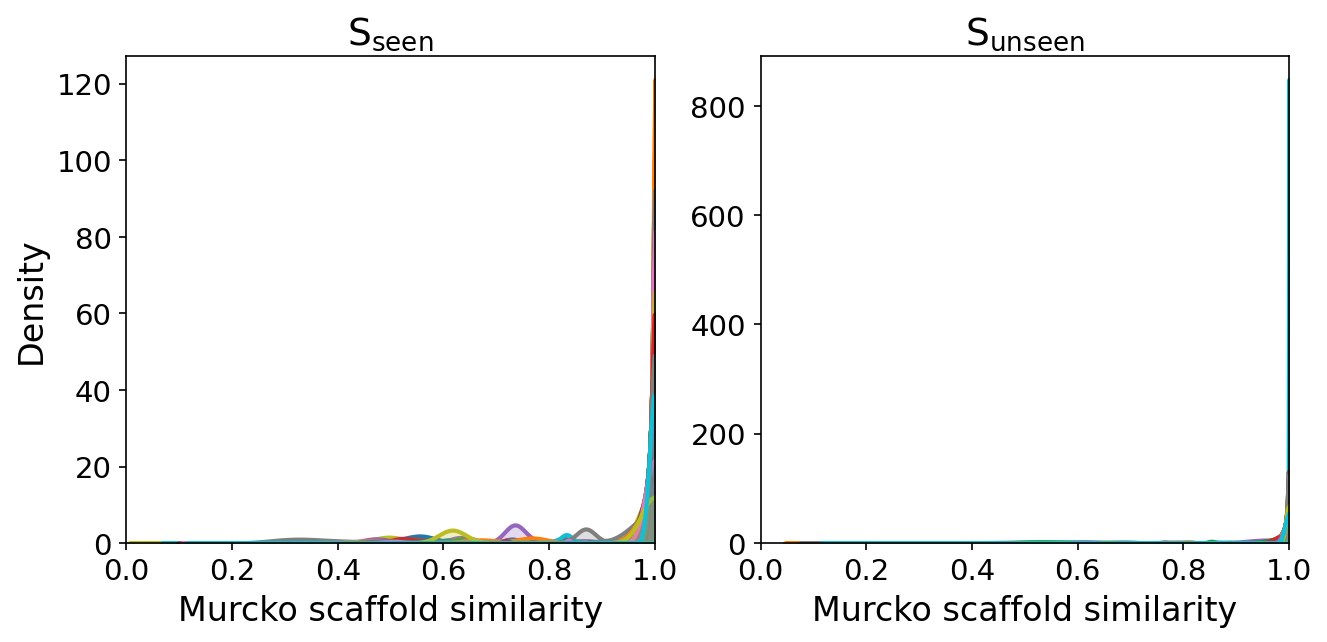

In [29]:
TEST = True

if TEST:
    _train_sim = train_sim.sample(n=100000)
    _testsca_sim = testsca_sim.sample(n=10000)
else:
    _train_sim, _testsca_sim = train_sim, testsca_sim

fig, axes = plt.subplots(1, 2, figsize=(10, 4.30), dpi=150)

for sid in range(100):
    murcko_scaffold_sim = _train_sim[str(sid)].dropna()
    sns.kdeplot(data=murcko_scaffold_sim, ax=axes[0], shade=True,
                linewidth=2, legend=False)
    axes[0].set_xlabel(xlabel='Murcko scaffold similarity', fontsize=16)
    axes[0].set_ylabel(ylabel='Density', fontsize=16)
    axes[0].tick_params(axis="both", which="major", labelsize=14)
    
axes[0].set_title(r'$\mathdefault{S}_{\mathdefault{seen}}$', fontsize=18)
axes[0].set_xlim(0, 1.)

for sid in range(100):
    murcko_scaffold_sim = _testsca_sim[str(sid)].dropna()
    sns.kdeplot(data=murcko_scaffold_sim, ax=axes[1], shade=True,
                linewidth=2, legend=False)
    axes[1].set_xlabel(xlabel='Murcko scaffold similarity', fontsize=16)
    axes[1].set_ylabel(ylabel='', fontsize=16)
    axes[1].tick_params(axis="both", which="major", labelsize=14)

axes[1].set_title(r'$\mathdefault{S}_{\mathdefault{unseen}}$', fontsize=18)
axes[1].set_xlim(0, 1.)
